In [1]:
%load_ext lab_black

In [2]:
from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


%matplotlib inline

from collections import deque

In [3]:
import pandas_datareader.data as web


df = web.DataReader("IBM", "yahoo", "2005/1/1").dropna()
df = df.rename_axis("Date").reset_index()
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2005-01-03,99.099998,97.250000,98.970001,97.750000,5295200.0,62.729687
1,2005-01-04,98.419998,96.519997,97.739998,96.699997,5711000.0,62.055878
2,2005-01-05,97.830002,96.400002,96.599998,96.500000,5646700.0,61.927532
3,2005-01-06,96.980003,96.050003,96.540001,96.199997,4561700.0,61.735004
4,2005-01-07,96.800003,95.470001,96.500000,95.779999,6200700.0,61.465485
...,...,...,...,...,...,...,...
4129,2021-05-28,144.330002,143.490005,144.210007,143.740005,2534600.0,143.740005
4130,2021-06-01,145.830002,143.750000,145.000000,144.190002,2417500.0,144.190002
4131,2021-06-02,145.750000,144.110001,144.619995,145.720001,2786900.0,145.720001
4132,2021-06-03,145.880005,144.039993,144.910004,145.550003,4130600.0,145.550003


In [4]:
window_size = 21

In [5]:
close_prices = df["Close"]
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df["Close"]

In [6]:
def create_timestamps_ds(series, timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)

    # starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)

    # feed the timestamps list
    for i in range(len(series) - 1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))

    # feed the labels lsit
    for i in range(len(series) - 1):
        labels.append(series[i + 1])

    assert len(time_stamps) == len(labels), "Something went wrong"

    # torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()

    return features, labels

In [7]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(
            1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0
        )
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        x_, _ = self.lstm_1(x)

        # gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [8]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(
    Xs, ys, test_size=0.25, random_state=42, shuffle=False
)


ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        loss = net.sample_elbo(
            inputs=datapoints,
            labels=labels,
            criterion=criterion,
            sample_nbr=3,
            complexity_cost_weight=1 / X_train.shape[0],
        )
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % 250 == 0:
            preds_test = net(X_test)[:, 0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print(
                "Iteration: {} Val-loss: {:.4f}".format(
                    str(iteration), loss_test
                )
            )

Iteration: 250 Val-loss: 0.0596
Iteration: 500 Val-loss: 0.0099
Iteration: 750 Val-loss: 0.0163
Iteration: 1000 Val-loss: 0.0146
Iteration: 1250 Val-loss: 0.0071
Iteration: 1500 Val-loss: 0.0068
Iteration: 1750 Val-loss: 0.0077
Iteration: 2000 Val-loss: 0.0063
Iteration: 2250 Val-loss: 0.0069
Iteration: 2500 Val-loss: 0.0105
Iteration: 2750 Val-loss: 0.0057
Iteration: 3000 Val-loss: 0.0112
Iteration: 3250 Val-loss: 0.0049
Iteration: 3500 Val-loss: 0.0094
Iteration: 3750 Val-loss: 0.0073


In [10]:
# pred_unscaled
original = close_prices_unscaled[1:][window_size:]
original

22       93.540001
23       94.510002
24       94.529999
25       94.129997
26       92.699997
           ...    
4129    143.740005
4130    144.190002
4131    145.720001
4132    145.550003
4133    147.419998
Name: Close, Length: 4112, dtype: float64

In [11]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
# df_pred = df_pred.set_index('Date')

In [12]:
def pred_stock_future(X_test, future_lengthx, sample_nbr=10):

    # sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler

    # creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0, :, 0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))

    # predict it and append to list
    for i in range(len(X_test)):
        # print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]

        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)

        if i % future_length == 0:
            # our inptus become the i index of our X_test
            # That tweak just helps us with shape issues
            test_begin = X_test[i : i + 1, :, :]
            test_deque = deque(
                test_begin[0, :, 0].tolist(), maxlen=window_size
            )

    # preds_test = np.array(preds_test).reshape(-1, 1)
    # preds_test_unscaled = scaler.inverse_transform(preds_test)

    return idx_pred, preds_test

In [13]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler

    preds_test = torch.tensor(preds_test)

    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    # print(pred_std)

    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    # gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)

    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)

    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [14]:
future_length = 7
sample_nbr = 4
ci_multiplier = 5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
(
    pred_mean_unscaled,
    upper_bound_unscaled,
    lower_bound_unscaled,
) = get_confidence_intervals(preds_test, ci_multiplier)

In [15]:
y = np.array(df.Close[-1028:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = under_upper == over_lower

print(
    "{} our predictions are in our confidence interval".format(np.mean(total))
)

0.8239299610894941 our predictions are in our confidence interval


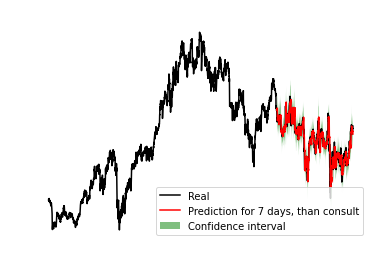

In [16]:
params = {
    "ytick.color": "w",
    "xtick.color": "w",
    "axes.labelcolor": "w",
    "axes.edgecolor": "w",
}

plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")

plt.plot(df_pred.index, df_pred.Close, color="black", label="Real")

plt.plot(
    idx_pred,
    pred_mean_unscaled,
    label="Prediction for {} days, than consult".format(future_length),
    color="red",
)

plt.fill_between(
    x=idx_pred,
    y1=upper_bound_unscaled[:, 0],
    y2=lower_bound_unscaled[:, 0],
    facecolor="green",
    label="Confidence interval",
    alpha=0.5,
)

plt.legend()

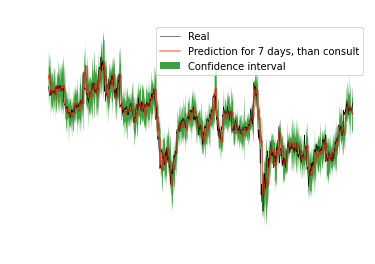

In [17]:
params = {
    "ytick.color": "w",
    "xtick.color": "w",
    "axes.labelcolor": "w",
    "axes.edgecolor": "w",
}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")


plt.fill_between(
    x=idx_pred,
    y1=upper_bound_unscaled[:, 0],
    y2=lower_bound_unscaled[:, 0],
    facecolor="green",
    label="Confidence interval",
    alpha=0.75,
)

plt.plot(
    idx_pred,
    df_pred.Close[-len(pred_mean_unscaled) :],
    label="Real",
    alpha=1,
    color="black",
    linewidth=0.5,
)

plt.plot(
    idx_pred,
    pred_mean_unscaled,
    label="Prediction for {} days, than consult".format(future_length),
    color="red",
    alpha=0.5,
)

plt.legend()